In [65]:
%load_ext autoreload
%autoreload 2
from my_code import model as m
from my_code import layers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from pennylane import numpy as np
data = np.loadtxt("data/parity.txt")
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}
X.requires_grad = False
Y.requires_grad = False
data = [X, Y]

for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

print("...")

X = [0. 0. 0. 0.], Y = -1
X = [0. 0. 0. 1.], Y =  1
X = [0. 0. 1. 0.], Y =  1
X = [0. 0. 1. 1.], Y = -1
X = [0. 1. 0. 0.], Y =  1
...


In [67]:
X, Y

(tensor([[0., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 1.],
         [0., 1., 0., 0.],
         [0., 1., 0., 1.],
         [0., 1., 1., 0.],
         [0., 1., 1., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 1.],
         [1., 0., 1., 0.],
         [1., 0., 1., 1.],
         [1., 1., 0., 0.],
         [1., 1., 0., 1.],
         [1., 1., 1., 0.],
         [1., 1., 1., 1.]], requires_grad=False),
 tensor([-1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
          1.,  1., -1.], requires_grad=False))

In [76]:

circuit_layers = [
    layers.basis_preparation(),
    layers.rotation_layer(), 
    layers.CNOTs_layer(), 
    layers.rotation_layer(), 
    layers.CNOTs_layer(), 
    layers.rotation_layer(), 
    layers.mesurament(qubits=[0])
]

In [81]:
S = m.score_predictor(n_qubits=4, data=data, circuit_layers=circuit_layers)


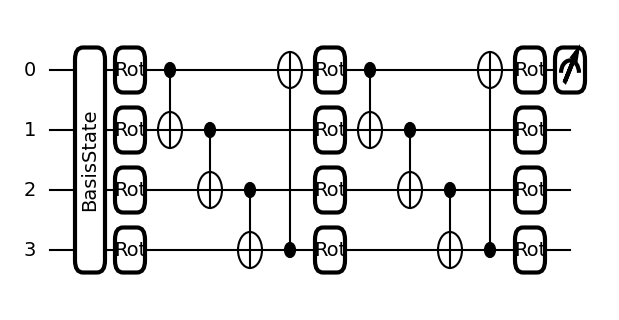

In [78]:
S.draw_circuit()

In [82]:
S.train(100)

Iter:    30 | Cost: 0.0016365 | Accuracy: 1.0000000 


KeyboardInterrupt: 